In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [36]:
pp_train = pd.read_csv("pp_train.csv")
pp_test = pd.read_csv("pp_test.csv")

pp_class = pp_train.copy()
pp_test_class = pp_test.copy()

### tolgo record con outliers

In [37]:
pp_class = pp_class[pp_class["outlier_no_type"] != True]
pp_test_class = pp_test_class[pp_test_class["outlier_no_type"] != True]

### Preprocessing delle variabili

Elimino righe videogame

In [38]:
pp_class = pp_class[pp_class['titleType'] != 'videoGame']
pp_class[['originalTitle', 'titleType']].head(15)

pp_test_class = pp_test_class[pp_test_class['titleType'] != 'videoGame']

Mapping variabile target

In [39]:

y = np.array(pp_class['titleType'])  # Il target originale


# Creiamo un dizionario che associa ogni categoria a un numero
y_map = {title: idx for idx, title in enumerate(pp_class['titleType'].unique())}

#aggiungo una nuova colonna
pp_class['titleType_encoded'] = pp_class['titleType'].map(y_map)
pp_test_class["titleType_encoded"] = pp_test_class['titleType'].map(y_map)

y_map # Per vedere la mappatura delle categorie

{'tvEpisode': 0,
 'movie': 1,
 'tvSeries': 2,
 'tvMiniSeries': 3,
 'short': 4,
 'tvMovie': 5,
 'tvSpecial': 6,
 'video': 7}

#### Encoding di titletype per multiclass classification task

In [40]:
# Extract target (y)
y_train = pp_class["titleType_encoded"].values  # Convert directly to NumPy
y_test = pp_test_class["titleType_encoded"].values  # Convert directly to NumPy

Conversione CanHaveEpisodes in binaria 0/1 

In [41]:
pp_class['canHaveEpisodes'] = pp_class['canHaveEpisodes'].astype(int)
pp_test_class['canHaveEpisodes'] = pp_test_class['canHaveEpisodes'].astype(int)

Rimuoviamo titleType dato che è già stata mappata + originaltitle e runtimeminutes non filled

In [42]:
column2drop = ['originalTitle', 'runtimeMinutes', 'titleType']
pp_class.drop(column2drop, axis=1, inplace=True)
pp_test_class.drop(column2drop, axis=1, inplace=True)

### BINARIZZAZIONE -> TOTALmEDIA E TOTALnOM

In [43]:
#train

#TOTALNOMINATIONS 
bins = [-1, 0, 2, 10, pp_class['totalNominations'].max()]
labels = ['ZeroNom', 'LowNom', 'MediumNom', 'VeryHighNom']
pp_class['totalNominations_bin'] = pd.cut(pp_class['totalNominations'], 
                                bins=bins, 
                                labels=labels)

#TOTALMEDIA
bins = [-1, 0, 1, 8, 50, pp_class['totalMedia'].max()]
labels = ['ZeroMedia', 'LowMedia', 'MediumMedia', 'HighMedia', 'VeryHighMedia']
pp_class['totalMedia_bin'] = pd.cut(pp_class['totalMedia'], bins=bins, labels=labels)

#FILL_RUNTIMEMINS_BRUNO 
bins = [0, 30, 60, 90,  float('inf') ]
labels = ['0_VeryLowRuntime', '1_LowRuntime', '2_MediumRuntime', '3_HighRuntime']
pp_class['runtime_bin'] = pd.cut(pp_class['runtimeMinutes_notitletype'], bins=bins, labels=labels)

#RATING 
bins = [-1, 3, 6, 7, 8, pp_class['rating'].max()]
labels = ['0_VeryLowRating', '1_LowRating', '2_MediumRating', '3_HighRating', "4_VeryHighRating"]
pp_class['rating_bin'] = pd.cut(pp_class['rating'], bins=bins, labels=labels)

#NUMVOTES 
labels = ['0_VeryLowVotes', '1_LowVotes', '2_MediumVotes', '3_HighVotes', '4_VeryHighVotes']
bins = [4, 15, 50, 150, 1000, float('inf')]  # include il min=5 e max=1.071.372
pp_class['numVotes_bin'] = pd.cut(pp_class['numVotes'], bins=bins, labels=labels, include_lowest=True)

#STARTYEAR
bins =[
    1878,  # Cinema delle origini e muto
    1930,  # Cinema sonoro classico e radio
    1955,  # TV B/N e colore, cinema widescreen
    1980,  # Video domestico e media transazionali
    2000,  # DVD, internet e mobile
    2015,  # Streaming integrato e nuovi media
    pp_class['startYear'].max()] #era corrente
labels = ['0_pre-1930', '1_1930-1954', '2_1955-1979', '3_1980-1999', '4_2000-2019', '5_post-2020']
pp_class['startYear_bin'] = pd.cut(pp_class['startYear'], bins=bins, labels=labels, include_lowest=True)

#TOTALCREDITS NON LOG-TRANSFORMED
labels = ['0_VeryLowCredits', '1_LowCredits', '2_MediumCredits', '3_HighCredits']
bins = [-1, 15, 35, 65, float('inf')]
pp_class['totalCredits_bin'] = pd.cut(pp_class['totalCredits'], bins=bins, labels=labels, include_lowest=True)

#CRITICREVIEWS NON LOG-TRANSFORMED
labels = [
    '0_NoCriticReviews',
    '1_FewCriticReviews',
    '2_ModerateCriticReviews',
    '3_ManyCriticReviews',
    '4_VeryHighCriticReviews',
    '5_ExtensiveCriticReviews'
]
bins = [-1, 0, 1, 5, 20, 45, float('inf')]
pp_class['criticReviewsTotal_bin'] = pd.cut(pp_class['criticReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

#NUMREGIONS NON LOG-TRANSFORMED
labels = ['0_FewRegions', '1_ModerateRegions', '2_ManyRegions']
bins = [0, 1, 8, float('inf')]
pp_class['numRegions_bin'] = pd.cut(pp_class['numRegions'], bins=bins, labels=labels, include_lowest=True)

#USERREVIEWSTOTAL NON LOG-TRANSFORMED
labels = ['0_NoUserReviews', '1_FewUserReviews', '2_ManyUserReviews', '3_VeryManyUserReviews']
bins = [-1, 0, 3, 30, float('inf')]
pp_class['userReviewsTotal_bin'] = pd.cut(pp_class['userReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

## COUNTRY OF ORIGIN freq-> 
bins = [-0.01, 0.03, 0.3, 1.0]
labels = ['0_LowFreqCountries', '1_MediumFreqCountries', '2_HighFreqCountries']
pp_class["country_freq_bin"] = pd.cut( pp_class["countryOfOrigin_freq_enc"], bins=bins,  labels=labels)

## COUNTRY OF ORIGIN CONTINENTI -> 
def discretize_continent_count(df, col_name, cont):
    new_col = f'{cont }_bin'
    
    def label(value):
        if value == 0:
            return f'0_not_{cont}'
       # elif value == 1:
        #    return f'one_{cont}'
        else:
            return f'1_is_{cont}'
    
    df[new_col] = df[col_name].apply(label)

# applico funzione
discretize_continent_count(pp_class, "countryOfOrigin_NA", "from_NorthAmerica")
discretize_continent_count(pp_class, "countryOfOrigin_EU", "from_Europe")
discretize_continent_count(pp_class, "countryOfOrigin_SA", "from_SouthAmerica")
discretize_continent_count(pp_class, "countryOfOrigin_AS", "from_Asia")
discretize_continent_count(pp_class, "countryOfOrigin_OC", "from_Oceania")
discretize_continent_count(pp_class, "countryOfOrigin_AF", "from_Africa")
discretize_continent_count(pp_class, "countryOfOrigin_UNK", "from_Unknown")

In [44]:
#test

#TOTALNOMINATIONS 
bins = [-1, 0, 2, 10, pp_test_class['totalNominations'].max()]
labels = ['ZeroNom', 'LowNom', 'MediumNom', 'VeryHighNom']
pp_test_class['totalNominations_bin'] = pd.cut(pp_test_class['totalNominations'], 
                                bins=bins, 
                                labels=labels)

#TOTALMEDIA
bins = [-1, 0, 1, 8, 50, pp_test_class['totalMedia'].max()]
labels = ['ZeroMedia', 'LowMedia', 'MediumMedia', 'HighMedia', 'VeryHighMedia']
pp_test_class['totalMedia_bin'] = pd.cut(pp_test_class['totalMedia'], bins=bins, labels=labels)


#FILL_RUNTIMEMINS_BRUNO 
bins = [0, 30, 60, 90,  pp_test_class['runtimeMinutes_notitletype'].max()]
labels = ['0_VeryLowRuntime', '1_LowRuntime', '2_MediumRuntime', '3_HighRuntime']
pp_test_class['runtime_bin'] = pd.cut(pp_test_class['runtimeMinutes_notitletype'], bins=bins, labels=labels)

#RATING 
bins = [-1, 3, 6, 7, 8, pp_test_class['rating'].max()]
labels = ['0_VeryLowRating', '1_LowRating', '2_MediumRating', '3_HighRating', "4_VeryHighRating"]
pp_test_class['rating_bin'] = pd.cut(pp_test_class['rating'], bins=bins, labels=labels)

#NUMVOTES 
labels = ['0_VeryLowVotes', '1_LowVotes', '2_MediumVotes', '3_HighVotes', '4_VeryHighVotes']
bins = [4, 15, 50, 150, 1000, float('inf')]  # include il min=5 e max=1.071.372
pp_test_class['numVotes_bin'] = pd.cut(pp_test_class['numVotes'], bins=bins, labels=labels, include_lowest=True)

#STARTYEAR
bins =[
    1877,  # Cinema delle origini e muto
    1930,  # Cinema sonoro classico e radio
    1955,  # TV B/N e colore, cinema widescreen
    1980,  # Video domestico e media transazionali
    2000,  # DVD, internet e mobile
    2015,  # Streaming integrato e nuovi media
    pp_test_class['startYear'].max()] #era corrente
labels = ['0_pre-1930', '1_1930-1954', '2_1955-1979', '3_1980-1999', '4_2000-2019', '5_post-2020']
pp_test_class['startYear_bin'] = pd.cut(pp_test_class['startYear'], bins=bins, labels=labels, include_lowest=True)

#TOTALCREDITS NON LOG-TRANSFORMED
labels = ['0_VeryLowCredits', '1_LowCredits', '2_MediumCredits', '3_HighCredits']
bins = [-1, 15, 35, 65, float('inf')]

pp_test_class['totalCredits_bin'] = pd.cut(pp_test_class['totalCredits'], bins=bins, labels=labels, include_lowest=True)

#CRITICREVIEWS NON LOG-TRANSFORMED
labels = [
    '0_NoCriticReviews',
    '1_FewCriticReviews',
    '2_ModerateCriticReviews',
    '3_ManyCriticReviews',
    '4_VeryHighCriticReviews',
    '5_ExtensiveCriticReviews'
]
bins = [-1, 0, 1, 5, 20, 45, float('inf')]
pp_test_class['criticReviewsTotal_bin'] = pd.cut(pp_test_class['criticReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

#NUMREGIONS NON LOG-TRANSFORMED
labels = ['0_FewRegions', '1_ModerateRegions', '2_ManyRegions']
bins = [0, 1, 8, float('inf')]
pp_test_class['numRegions_bin'] = pd.cut(pp_test_class['numRegions'], bins=bins, labels=labels, include_lowest=True)

#USERREVIEWSTOTAL NON LOG-TRANSFORMED
labels = ['0_NoUserReviews', '1_FewUserReviews', '2_ManyUserReviews', '3_VeryManyUserReviews']
bins = [-1, 0, 3, 30, float('inf')]

pp_test_class['userReviewsTotal_bin'] = pd.cut(pp_test_class['userReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

## COUNTRY OF ORIGIN FREQ ENC 
bins = [-0.01, 0.03, 0.3, 1.0]
labels = ['0_LowFreqCountries', '1_MediumFreqCountries', '2_HighFreqCountries']

pp_test_class["country_freq_bin"] = pd.cut( pp_test_class["countryOfOrigin_freq_enc"], bins=bins,  labels=labels)

## COUNTRY OF ORIGIN CONTINENTI -> 
def discretize_continent_count(df, col_name, cont):
    new_col = f'{cont }_bin'
    
    def label(value):
        if value == 0:
            return f'0_not_{cont}'
       # elif value == 1:
        #    return f'one_{cont}'
        else:
            return f'1_is_{cont}'
    
    df[new_col] = df[col_name].apply(label)

# applico funzione
discretize_continent_count(pp_test_class, "countryOfOrigin_NA", "from_NorthAmerica")
discretize_continent_count(pp_test_class, "countryOfOrigin_EU", "from_Europe")
discretize_continent_count(pp_test_class, "countryOfOrigin_SA", "from_SouthAmerica")
discretize_continent_count(pp_test_class, "countryOfOrigin_AS", "from_Asia")
discretize_continent_count(pp_test_class, "countryOfOrigin_OC", "from_Oceania")
discretize_continent_count(pp_test_class, "countryOfOrigin_AF", "from_Africa")
discretize_continent_count(pp_test_class, "countryOfOrigin_UNK", "from_Unknown")



In [45]:
pp_class.head()

,rating,startYear,endYear,awardWins,numVotes,totalImages,totalVideos,totalCredits,criticReviewsTotal,awardNominationsExcludeWins,...,numRegions_bin,userReviewsTotal_bin,country_freq_bin,from_NorthAmerica_bin,from_Europe_bin,from_SouthAmerica_bin,from_Asia_bin,from_Oceania_bin,from_Africa_bin,from_Unknown_bin
0,8,1995,1995.0,0.0,779,1,0,21,1,0,...,0_FewRegions,0_NoUserReviews,2_HighFreqCountries,1_is_from_NorthAmerica,0_not_from_Europe,0_not_from_SouthAmerica,0_not_from_Asia,0_not_from_Oceania,0_not_from_Africa,0_not_from_Unknown
1,6,1992,1992.0,0.0,38,1,0,24,0,0,...,0_FewRegions,1_FewUserReviews,0_LowFreqCountries,0_not_from_NorthAmerica,1_is_from_Europe,0_not_from_SouthAmerica,0_not_from_Asia,0_not_from_Oceania,0_not_from_Africa,0_not_from_Unknown
2,6,2021,NaN,0.0,15,22,0,56,0,0,...,0_FewRegions,0_NoUserReviews,0_LowFreqCountries,1_is_from_NorthAmerica,0_not_from_Europe,0_not_from_SouthAmerica,0_not_from_Asia,0_not_from_Oceania,0_not_from_Africa,0_not_from_Unknown
3,8,2020,2020.0,1.0,15718,347,2,47,4,1,...,2_ManyRegions,3_VeryManyUserReviews,0_LowFreqCountries,0_not_from_NorthAmerica,0_not_from_Europe,0_not_from_SouthAmerica,1_is_from_Asia,0_not_from_Oceania,0_not_from_Africa,0_not_from_Unknown
5,8,1995,1995.0,0.0,96,5,0,110,0,0,...,0_FewRegions,0_NoUserReviews,2_HighFreqCountries,1_is_from_NorthAmerica,0_not_from_Europe,0_not_from_SouthAmerica,0_not_from_Asia,0_not_from_Oceania,0_not_from_Africa,0_not_from_Unknown


###  creazione array di valori -> ora senza Can Have ep e Is_Short

In [ ]:
features = [
       'rating_bin',
       'startYear_bin', 
       'totalCredits_bin',
       'criticReviewsTotal_bin', 
       #'canHaveEpisodes', 
       'userReviewsTotal_bin',  
       'country_freq_bin', 
       'from_NorthAmerica_bin', 
       'totalMedia_bin',
       'runtime_bin',
       #'numVotes_bin',
       'numRegions_bin', 
       #'from_Europe_bin', 
       # 'from_SouthAmerica_bin', 'from_Asia_bin',  'from_Oceania_bin', 'from_Africa_bin', 'from_Unknown_bin',
       'totalNominations_bin',

      "is_Documentary", "is_History", "is_Adventure", "is_Thriller", "is_Game-Show", "is_Comedy", "is_Sci-Fi", "is_Romance", "is_Biography",
        "is_Musical", "is_Western", "is_Music", "is_Film-Noir", "is_Adult", "is_Reality-TV", "is_News", "is_Action", "is_Crime", 
        #"is_Short", 
        "is_Fantasy", "is_Family", "is_Mystery", "is_Talk-Show", "is_Drama", "is_Sport", "is_War", "is_Horror", "is_Animation"
       ]

X_train = pp_class[features].values
X_test = pp_test_class[features].values

In [47]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
X_train= encoder.fit_transform(X_train)  # dove X ha solo colonne categoriche (incluse le binned)
X_test= encoder.transform(X_test)  # dove X ha solo colonne categoriche (incluse le binned)


### Splitting in validation 
##### -> penso su y_train (array valori multilabeled)

In [48]:
X_train2, X_val, y_train2, y_val = train_test_split(
     X_train, y_train, test_size=0.2, random_state=32
)

In [49]:
print(X_train2.shape, X_val.shape, X_train.shape
      , X_test.shape
      )

(12626, 39) (3157, 39) (15783, 39) (5246, 39)


In [50]:
# CATEGORICAL
X_train2_tr = X_train2
X_val_tr = X_val

X_train_tr = X_train
X_test_tr = X_test

## NAIVE BAYES

In [51]:
#clf = GaussianNB()
#clf = ComplementNB(alpha=1.0) -> non va perchè ci sono valori negativi
clf = CategoricalNB()

In [52]:
clf.fit(X_train2_tr, y_train2)

CategoricalNB()

# Predicting on validation set

In [53]:
y_pred = clf.predict(X_val_tr)
y_pred

array([2, 2, 0, ..., 0, 7, 7], dtype=int64)

In [54]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_val))  

3157
3157


In [55]:
print(set(y_val)) 
print(set(y_pred))  # se qui manca una classe rispetto a sopra vuol dire che non l'ha riconosciuta 

{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 3, 4, 5, 6, 7}


In [56]:
print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Test accuracy: 0.7288565093443142

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       952
           1       0.80      0.84      0.82      1072
           2       0.54      0.40      0.46       268
           3       0.08      0.04      0.05        26
           4       0.76      0.86      0.81       470
           5       0.27      0.16      0.20       179
           6       0.26      0.23      0.24        31
           7       0.49      0.47      0.48       159

    accuracy                           0.73      3157
   macro avg       0.50      0.48      0.48      3157
weighted avg       0.71      0.73      0.72      3157



In [57]:
clf.predict_proba(X_val_tr)
#prob che un record appartenga alle classi

array([[6.35766829e-02, 2.57962456e-01, 4.69077378e-01, ...,
        2.85224792e-02, 4.67917105e-04, 2.85623551e-04],
       [1.82990571e-01, 5.80745679e-02, 4.09549160e-01, ...,
        9.89569094e-02, 9.38490317e-02, 4.35501228e-02],
       [7.19084751e-01, 1.22297367e-03, 2.71551595e-01, ...,
        1.75517083e-03, 2.96843682e-03, 5.69966858e-04],
       ...,
       [9.97590033e-01, 8.96093419e-08, 9.71040557e-04, ...,
        4.88259809e-05, 1.55671810e-06, 1.02539032e-03],
       [1.41737407e-05, 4.99452832e-03, 2.13975558e-05, ...,
        6.81767088e-04, 3.93117796e-03, 9.90217816e-01],
       [1.87772423e-03, 2.36463824e-02, 4.80569638e-04, ...,
        5.98060388e-03, 4.40210190e-02, 9.22480887e-01]])

roc test

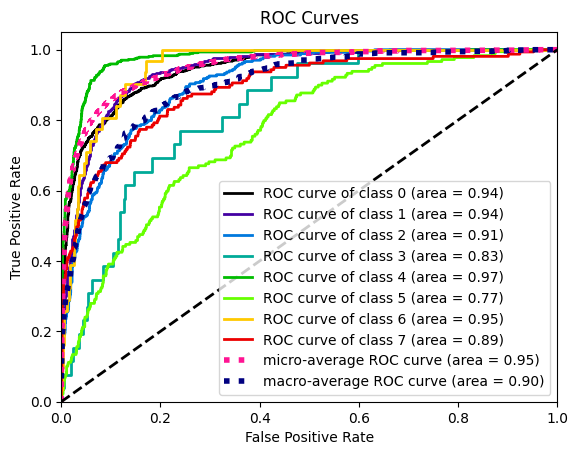

0.900829262355502


In [58]:
plot_roc(y_val, clf.predict_proba(X_val_tr))
plt.show()
print(roc_auc_score(y_val, clf.predict_proba(X_val_tr), multi_class="ovr", average="macro"))

verifica overfitting

Performance sul Training set:
Accuracy: 0.7236
F1 Score: 0.7134

Performance sul Validation set:
Accuracy: 0.7289
F1 Score: 0.7155


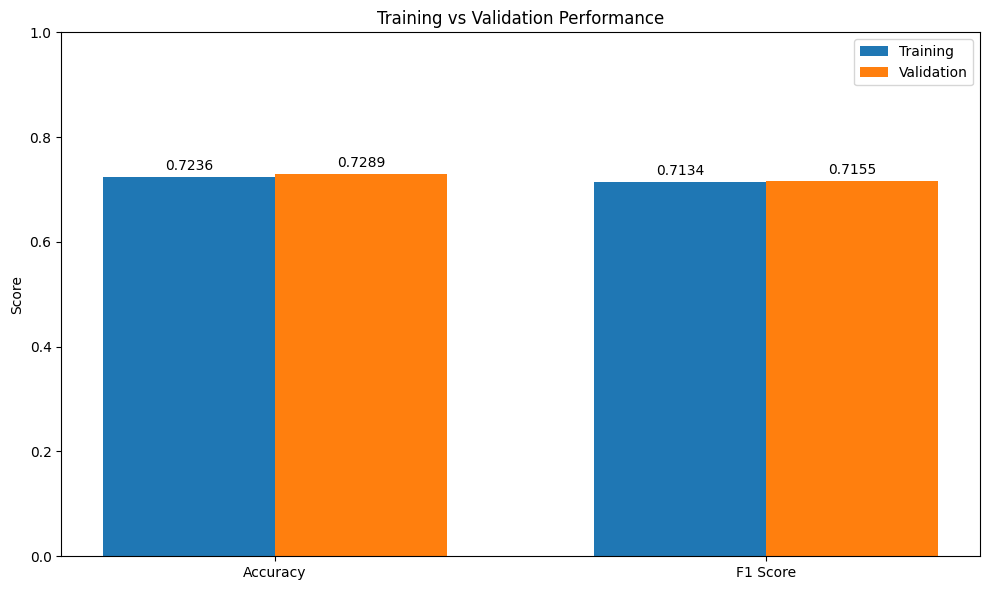

In [59]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train2_tr)
train_accuracy = accuracy_score(y_train2, y_pred_train)
train_f1 = f1_score(y_train2, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_tr)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

#### Distribuzioni classi nel train set
- classi con < support sono quelle con performance peggiori
- calitare se togliere classi (togliendo 7,8,9 migliora molto)

In [60]:
class_distribution = pd.Series(y_train2).value_counts().sort_index()

# Mostra i conteggi
print("Distribuzione delle classi nel training set:")
print(class_distribution)

Distribuzione delle classi nel training set:
0    3738
1    4370
2    1069
3     160
4    1912
5     665
6     127
7     585
Name: count, dtype: int64


confusion matrix 

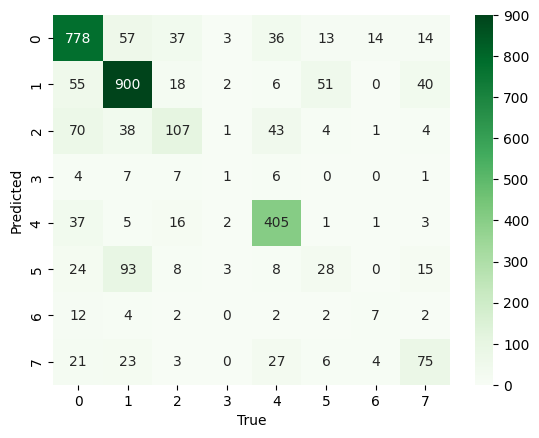

In [61]:
classes_unique = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# Proper testing on the test set -> ora senza Can Have ep e Is_Short

In [62]:
#clf = GaussianNB()
clf = CategoricalNB()
clf.fit(X_train_tr, y_train)
y_pred = clf.predict(X_test_tr)
y_pred
# era y_tpred

array([4, 1, 0, ..., 1, 2, 4], dtype=int64)

In [63]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_test))  

5246
5246


Performance sul Training set:
Accuracy: 0.7245
F1 Score: 0.7137

Performance sul test set:
Accuracy: 0.7200
F1 Score: 0.7075


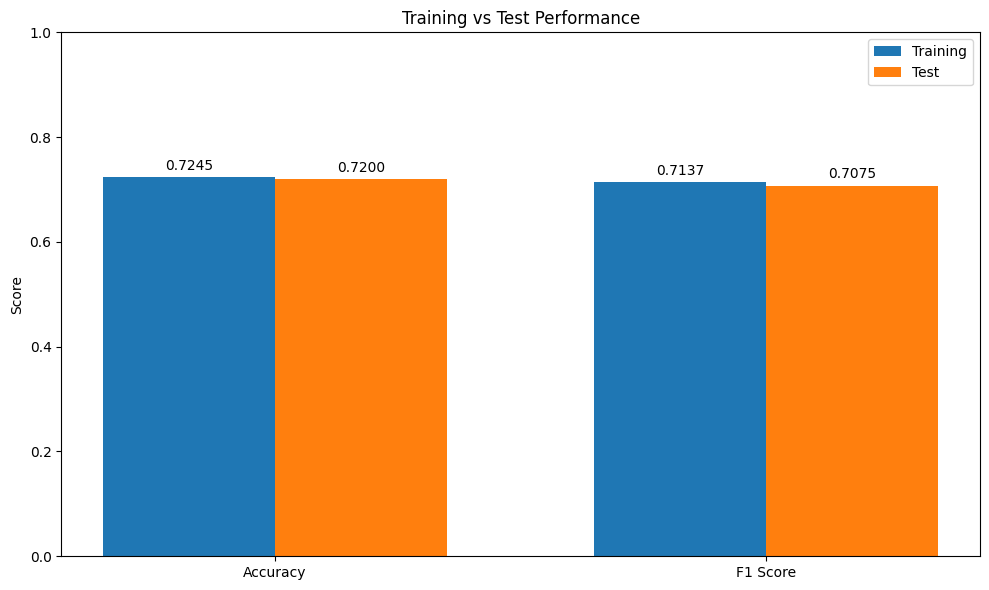

In [64]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_tr)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# Valutazione sul test set
y_pred_test = clf.predict(X_test_tr)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='weighted')
                        ### gaia ha messo y_tpred

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul test set:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
test_scores = [test_accuracy, test_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

ax.set_ylabel('Score')
ax.set_title('Training vs Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [65]:
class_mapping = {
    'tvEpisode': 0,
    'movie': 1,
    'tvSeries': 2,
    'tvMiniSeries': 3,
    'short': 4,
    'tvMovie': 5,
    'tvSpecial': 6,
    'video': 7
}
index_to_class = {v: k for k, v in class_mapping.items()}
target_names = [index_to_class[i] for i in range(len(index_to_class))]

print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

Test accuracy: 0.7199771254288982

Classification Report:
              precision    recall  f1-score   support

   tvEpisode       0.77      0.79      0.78      1596
       movie       0.82      0.83      0.82      1848
    tvSeries       0.51      0.39      0.44       437
tvMiniSeries       0.06      0.01      0.02        68
       short       0.73      0.88      0.80       728
     tvMovie       0.28      0.15      0.19       288
   tvSpecial       0.16      0.26      0.20        42
       video       0.38      0.43      0.40       239

    accuracy                           0.72      5246
   macro avg       0.46      0.47      0.46      5246
weighted avg       0.70      0.72      0.71      5246



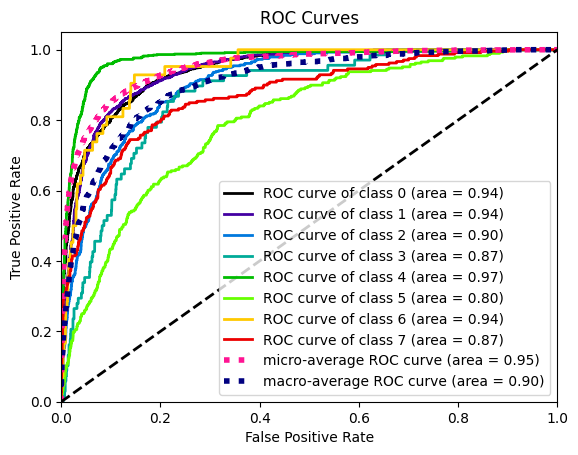

In [66]:
y_test_pred_proba = clf.predict_proba(X_test_tr)
# plot_roc(y_test, y_test_pred_proba)
# plt.show()

import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_test_pred_proba)
plt.show()

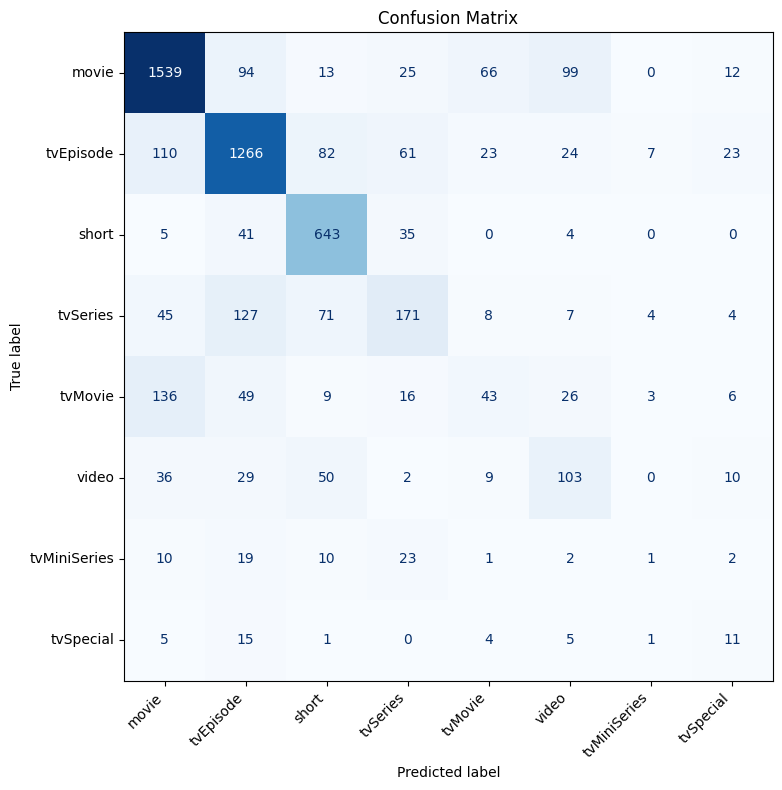

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Mappa delle classi leggibili (invertita: da codice numerico a etichetta)
label_map = {0: 'tvEpisode',
             1: 'movie',
             2: 'tvSeries',
             3: 'tvMiniSeries',
             4: 'short',
             5: 'tvMovie',
             6: 'tvSpecial',
             7: 'video'}

# Ordina le classi per frequenza
class_counts = Counter(y_test)
classes = np.array([c for c, _ in class_counts.most_common()])
display_labels = [label_map[c] for c in classes]

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred, labels=classes)

# Crea figura e assi
fig, ax = plt.subplots(figsize=(10, 8))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap='Blues', colorbar=False, ax=ax)

# Ruota etichette asse x per migliorare leggibilità
ax.set_xticklabels(display_labels, rotation=45, ha='right')

# Ruota etichette asse y verticalmente e centra
ax.set_yticklabels(display_labels, rotation=0, ha='right', va='center')

# Titolo
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

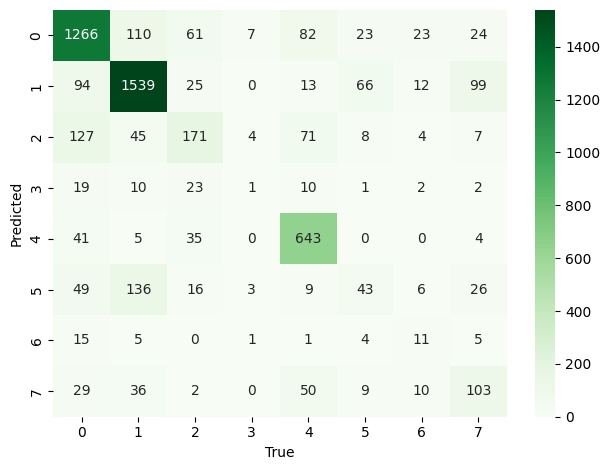

In [68]:
classes_unique = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

#### dummy classifier 

In [69]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create dummy classifier (most frequent class strategy)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_tr, y_train)

# Predict and evaluate
y_pred = dummy.predict(X_test_tr)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.3522683949675944
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1596
           1       0.35      1.00      0.52      1848
           2       0.00      0.00      0.00       437
           3       0.00      0.00      0.00        68
           4       0.00      0.00      0.00       728
           5       0.00      0.00      0.00       288
           6       0.00      0.00      0.00        42
           7       0.00      0.00      0.00       239

    accuracy                           0.35      5246
   macro avg       0.04      0.12      0.07      5246
weighted avg       0.12      0.35      0.18      5246



C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
